# Visualization Tutorial 1: Neural Data Visualization

This tutorial demonstrates the core neural data visualization functions in BrainTools. We'll explore how to visualize spike trains, population activity, connectivity patterns, and other essential neural data representations.

## Learning Objectives

In this tutorial, we will explore the core neural data visualization functions in BrainTools:

- **`spike_raster()`**: Visualizing individual spike events across neurons
- **`population_activity()`**: Showing aggregate neural activity patterns
- **`connectivity_matrix()`**: Displaying network connectivity patterns
- **`isi_distribution()`**: Analyzing inter-spike interval distributions
- **`spike_histogram()`**: Creating peri-stimulus time histograms (PSTH)
- **`firing_rate_map()`**: Visualizing spatial firing patterns


## Setup and Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Import braintools visualization functions
import braintools

# Set random seed for reproducibility
np.random.seed(42)

# Apply neural styling theme
braintools.visualize.neural_style()

## 1. Generating Simulated Neural Data

Let's start by generating realistic neural data that we'll use throughout this tutorial.

In [2]:
def generate_spike_trains(n_neurons=50,
                          duration=10.0,
                          base_rate=5.0,
                          burst_prob=0.1,
                          burst_rate=50.0):
    """
    Generate realistic spike trains with bursting behavior.
    
    Parameters:
    - n_neurons: Number of neurons
    - duration: Simulation duration (seconds)
    - base_rate: Base firing rate (Hz)
    - burst_prob: Probability of burst events
    - burst_rate: Firing rate during bursts (Hz)
    """
    spike_trains = []

    for i in range(n_neurons):
        # Generate base spike times using Poisson process
        n_spikes_base = np.random.poisson(base_rate * duration)
        spike_times = np.sort(np.random.uniform(0, duration, n_spikes_base))

        # Add burst events
        n_bursts = np.random.poisson(burst_prob * duration)
        for _ in range(n_bursts):
            burst_start = np.random.uniform(0, duration - 0.1)
            burst_duration = np.random.exponential(0.05)  # Short bursts
            n_burst_spikes = np.random.poisson(burst_rate * burst_duration)

            if n_burst_spikes > 0:
                burst_spikes = np.sort(np.random.uniform(
                    burst_start, burst_start + burst_duration, n_burst_spikes
                ))
                spike_times = np.concatenate([spike_times, burst_spikes])

        spike_times = np.sort(spike_times)
        spike_trains.append(spike_times)

    return spike_trains


def generate_population_activity(spike_trains, dt=0.001, sigma=0.01):
    """
    Convert spike trains to population activity with Gaussian smoothing.
    """
    duration = max([max(train) if len(train) > 0 else 0 for train in spike_trains])
    time_bins = np.arange(0, duration + dt, dt)

    # Create spike count matrix
    spike_matrix = np.zeros((len(time_bins), len(spike_trains)))

    for i, train in enumerate(spike_trains):
        if len(train) > 0:
            spike_indices = np.digitize(train, time_bins) - 1
            spike_indices = spike_indices[spike_indices < len(time_bins)]
            spike_matrix[spike_indices, i] = 1

    # Apply Gaussian smoothing
    from scipy.ndimage import gaussian_filter1d
    smoothed_activity = gaussian_filter1d(spike_matrix, sigma=sigma / dt, axis=0)

    return time_bins, smoothed_activity


def generate_connectivity_matrix(n_neurons=50, sparsity=0.2, exc_ratio=0.8):
    """
    Generate a realistic connectivity matrix.
    """
    # Create sparse random connectivity
    connectivity = np.random.rand(n_neurons, n_neurons)
    connectivity[connectivity > sparsity] = 0

    # Set diagonal to zero (no self-connections)
    np.fill_diagonal(connectivity, 0)

    # Make some connections inhibitory
    n_inhibitory = int(n_neurons * (1 - exc_ratio))
    inhibitory_neurons = np.random.choice(n_neurons, n_inhibitory, replace=False)

    # Scale connection strengths
    connectivity[connectivity > 0] = np.random.lognormal(0, 0.5,
                                                         np.sum(connectivity > 0))

    # Make inhibitory connections negative
    for neuron in inhibitory_neurons:
        connectivity[neuron, :] *= -1

    return connectivity


# Generate sample data
print("Generating simulated neural data...")
n_neurons = 50
duration = 10.0

spike_trains = generate_spike_trains(n_neurons, duration)
time_bins, population_data = generate_population_activity(spike_trains)
connectivity_matrix = generate_connectivity_matrix(n_neurons)

print(f"Generated data for {n_neurons} neurons over {duration} seconds")
print(f"Total spikes: {sum(len(train) for train in spike_trains)}")
print(f"Population activity shape: {population_data.shape}")
print(f"Connectivity matrix shape: {connectivity_matrix.shape}")

Generating simulated neural data...
Generated data for 50 neurons over 10.0 seconds
Total spikes: 2511
Population activity shape: (9999, 50)
Connectivity matrix shape: (50, 50)


## 2. Spike Raster Plots

Spike raster plots are fundamental for visualizing neural activity patterns. Each dot represents a spike from a specific neuron at a specific time.

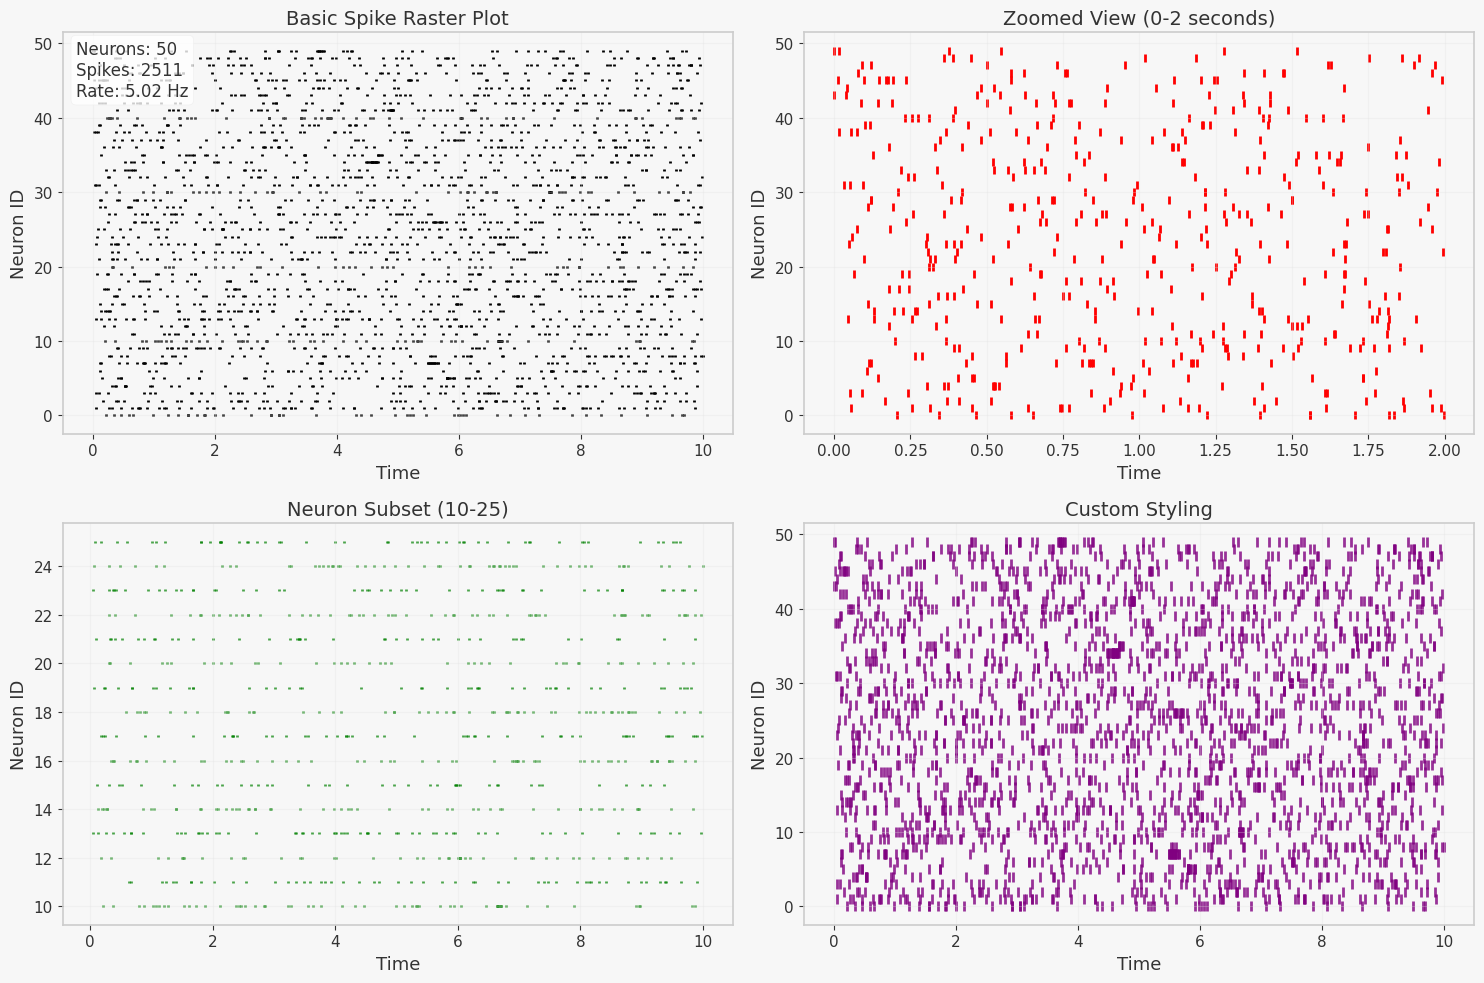


Spike Raster Plot Features:
- Each row represents one neuron
- Each dot represents a spike event
- Time is shown on the x-axis
- Statistics can be displayed (neuron count, spike count, firing rate)
- Supports zooming and neuron subsetting


In [3]:
# Basic spike raster plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Basic raster plot
braintools.visualize.spike_raster(spike_trains,
                                  ax=axes[0, 0],
                                  title="Basic Spike Raster Plot",
                                  show_stats=True)

# 2. Zoomed-in view (first 2 seconds)
braintools.visualize.spike_raster(spike_trains,
                                  ax=axes[0, 1],
                                  time_range=(0, 2),
                                  title="Zoomed View (0-2 seconds)",
                                  color='red',
                                  markersize=30)

# 3. Subset of neurons
braintools.visualize.spike_raster(spike_trains,
                                  ax=axes[1, 0],
                                  neuron_range=(10, 25),
                                  title="Neuron Subset (10-25)",
                                  color='green',
                                  alpha=0.7)

# 4. Custom styling
braintools.visualize.spike_raster(spike_trains,
                                  ax=axes[1, 1],
                                  title="Custom Styling",
                                  color='purple',
                                  marker='|',
                                  markersize=50,
                                  alpha=0.8)

plt.tight_layout()
plt.show()

print("\nSpike Raster Plot Features:")
print("- Each row represents one neuron")
print("- Each dot represents a spike event")
print("- Time is shown on the x-axis")
print("- Statistics can be displayed (neuron count, spike count, firing rate)")
print("- Supports zooming and neuron subsetting")

## 3. Population Activity Visualization

Population activity plots show the aggregate neural activity over time using different aggregation methods.

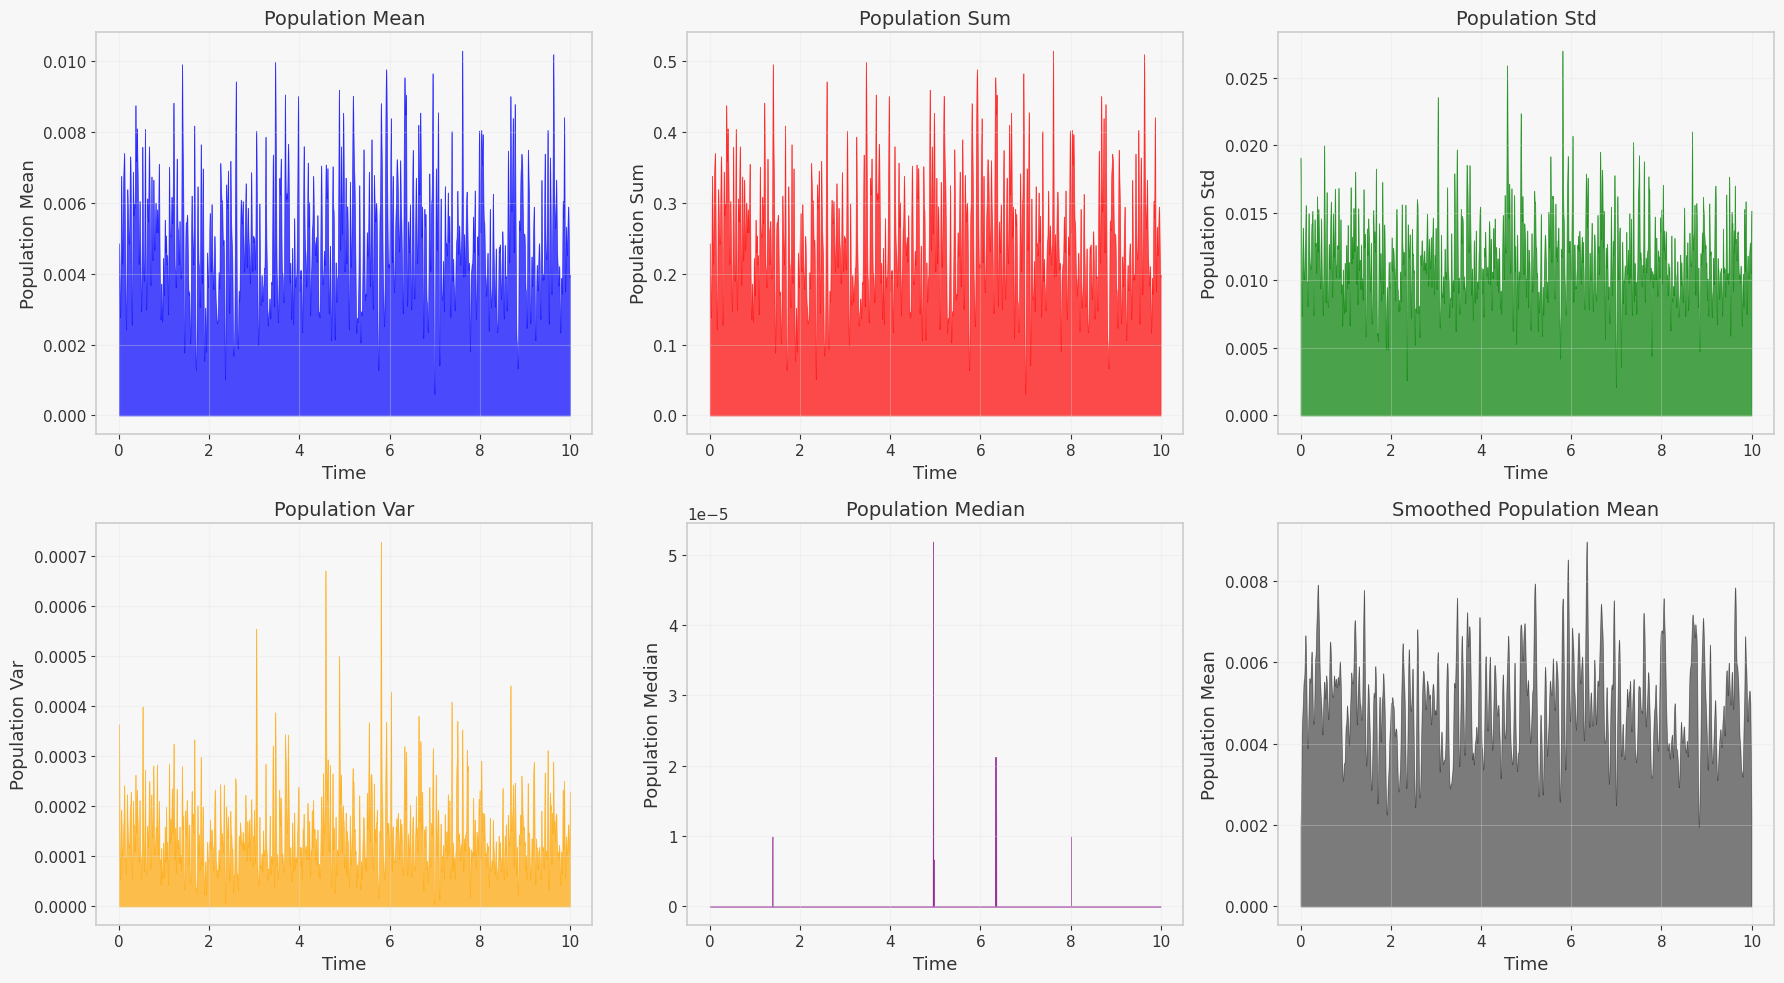


Population Activity Features:
- Mean: Average activity across all neurons
- Sum: Total activity (useful for spike counts)
- Std: Variability in population activity
- Var: Variance in population activity
- Median: Robust central tendency measure
- Smoothing can be applied with window_size parameter


In [4]:
# Population activity with different aggregation methods
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

methods = ['mean', 'sum', 'std', 'var', 'median']
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (method, color) in enumerate(zip(methods, colors)):
    row = i // 3
    col = i % 3

    braintools.visualize.population_activity(population_data,
                                             time=time_bins,
                                             method=method,
                                             ax=axes[row, col],
                                             title=f"Population {method.capitalize()}",
                                             color=color,
                                             alpha=0.7)

# Smoothed population activity
braintools.visualize.population_activity(population_data,
                                         time=time_bins,
                                         method='mean',
                                         window_size=50,
                                         ax=axes[1, 2],
                                         title="Smoothed Population Mean",
                                         color='black',
                                         fill=True,
                                         alpha=0.5)

plt.tight_layout()
plt.show()

print("\nPopulation Activity Features:")
print("- Mean: Average activity across all neurons")
print("- Sum: Total activity (useful for spike counts)")
print("- Std: Variability in population activity")
print("- Var: Variance in population activity")
print("- Median: Robust central tendency measure")
print("- Smoothing can be applied with window_size parameter")

## 4. Connectivity Matrix Visualization

Connectivity matrices show the strength and pattern of connections between neurons in a network.

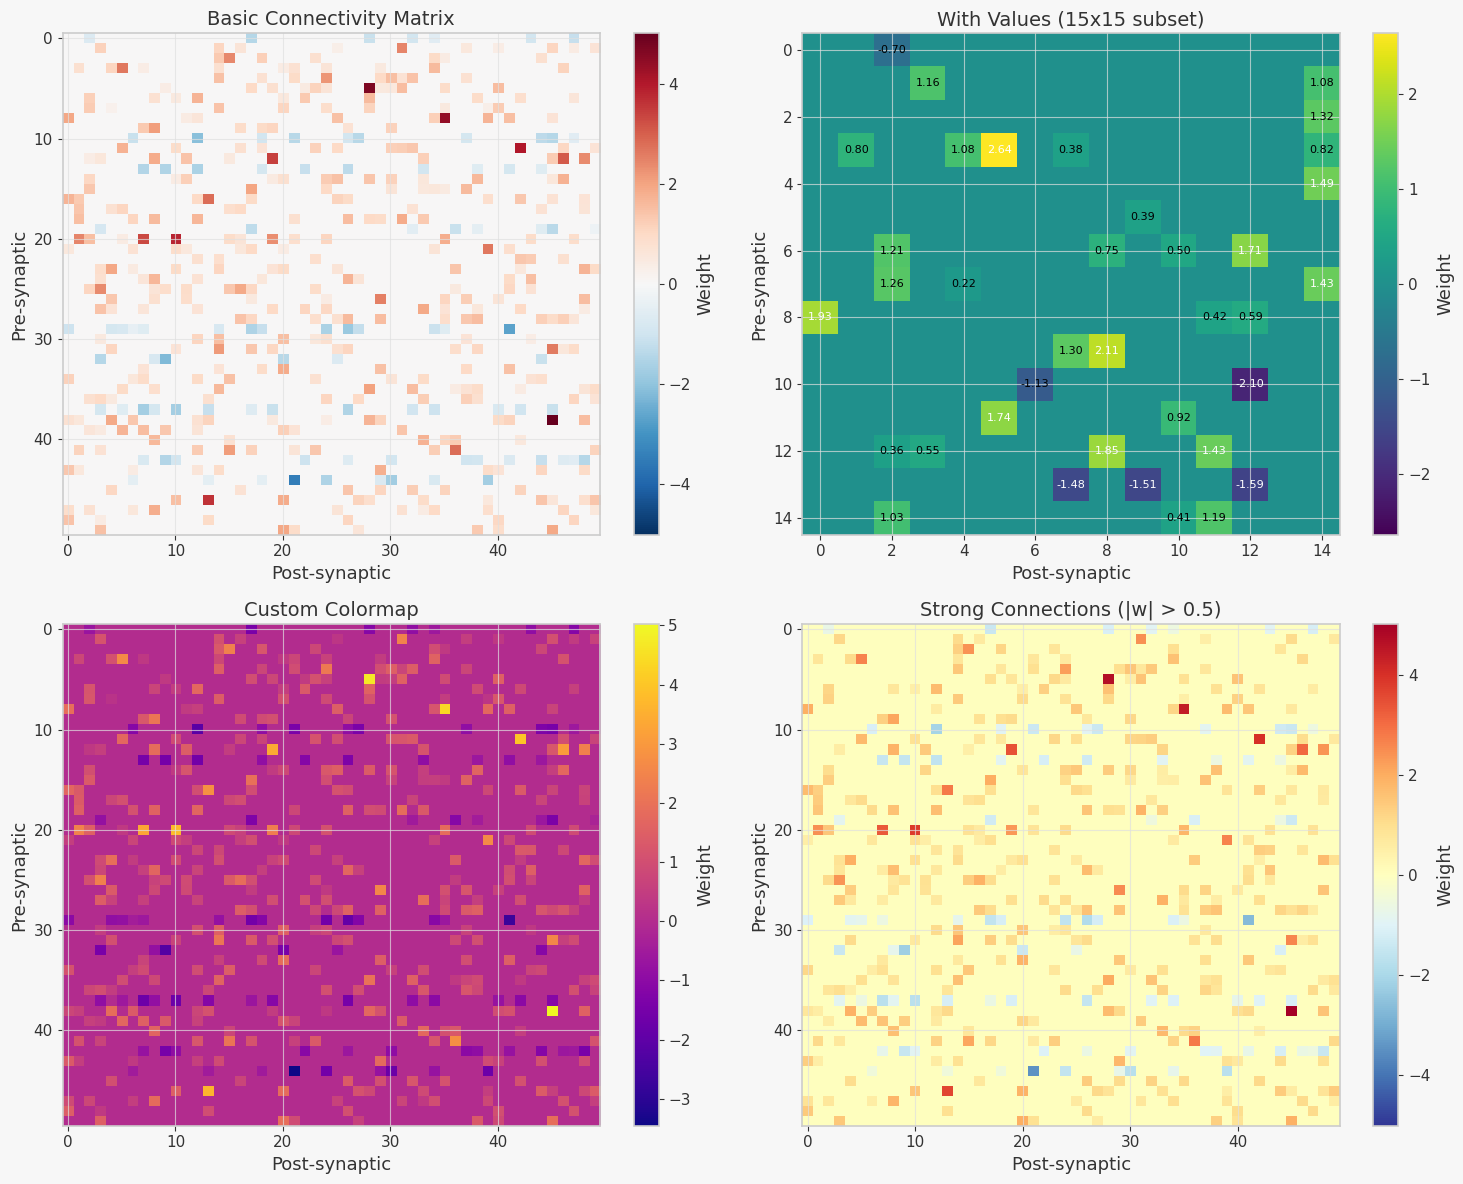


Connectivity Matrix Features:
- Rows: Pre-synaptic neurons
- Columns: Post-synaptic neurons
- Positive values: Excitatory connections
- Negative values: Inhibitory connections
- center_zero=True centers colormap at zero
- Can display actual connection values
- Thresholding helps visualize strong connections


In [5]:
# Connectivity matrix visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Basic connectivity matrix
braintools.visualize.connectivity_matrix(connectivity_matrix,
                                         ax=axes[0, 0],
                                         title="Basic Connectivity Matrix",
                                         cmap='RdBu_r',
                                         center_zero=True)

# 2. With connection values displayed
# Show values for a smaller subset to avoid clutter
subset_matrix = connectivity_matrix[:15, :15]
braintools.visualize.connectivity_matrix(subset_matrix,
                                         ax=axes[0, 1],
                                         title="With Values (15x15 subset)",
                                         show_values=True,
                                         value_threshold=0.1,
                                         cmap='viridis')

# 3. Custom colormap and styling
braintools.visualize.connectivity_matrix(connectivity_matrix,
                                         ax=axes[1, 0],
                                         title="Custom Colormap",
                                         cmap='plasma',
                                         center_zero=False,
                                         show_colorbar=True)

# 4. Thresholded connections
# Only show strong connections
threshold = 0.5
thresholded_matrix = connectivity_matrix.copy()
thresholded_matrix[np.abs(thresholded_matrix) < threshold] = 0

braintools.visualize.connectivity_matrix(thresholded_matrix,
                                         ax=axes[1, 1],
                                         title=f"Strong Connections (|w| > {threshold})",
                                         cmap='RdYlBu_r',
                                         center_zero=True)

plt.tight_layout()
plt.show()

print("\nConnectivity Matrix Features:")
print("- Rows: Pre-synaptic neurons")
print("- Columns: Post-synaptic neurons")
print("- Positive values: Excitatory connections")
print("- Negative values: Inhibitory connections")
print("- center_zero=True centers colormap at zero")
print("- Can display actual connection values")
print("- Thresholding helps visualize strong connections")

## 5. Inter-Spike Interval (ISI) Analysis

ISI distributions reveal important information about neural firing patterns and regularity.

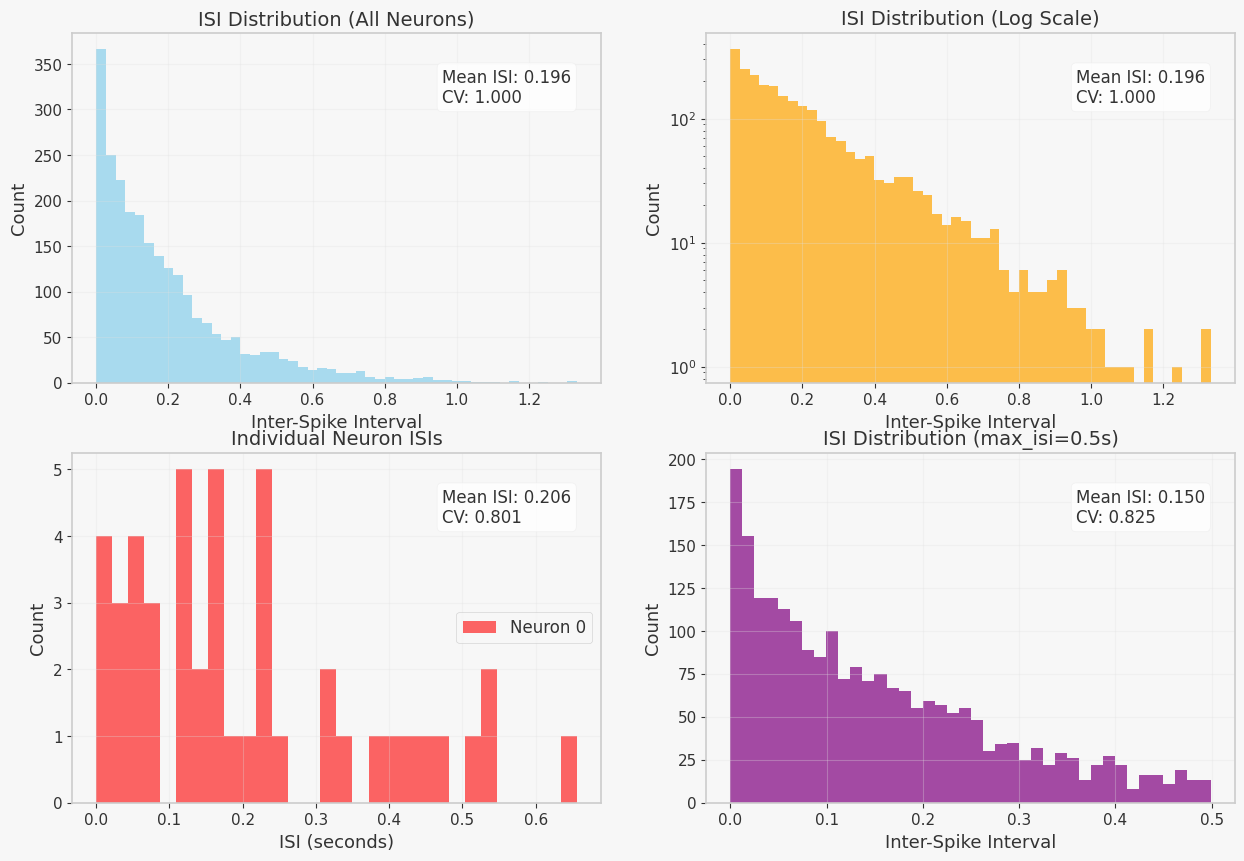

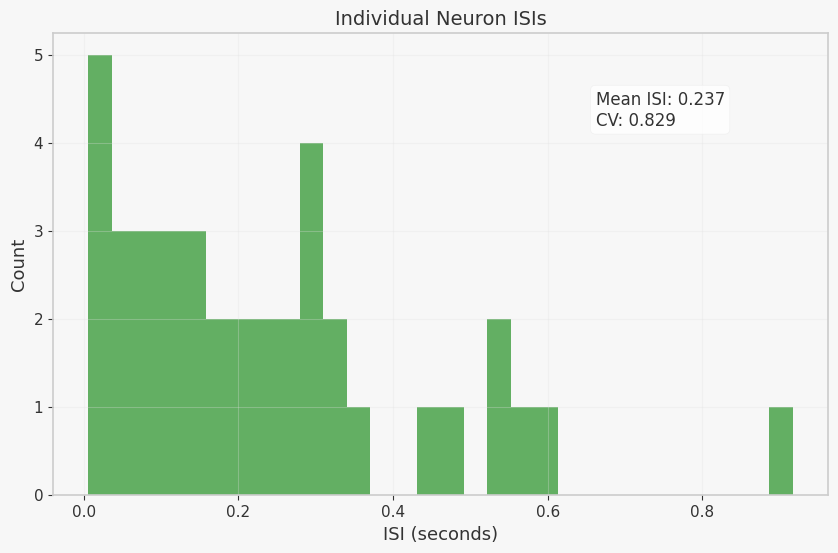

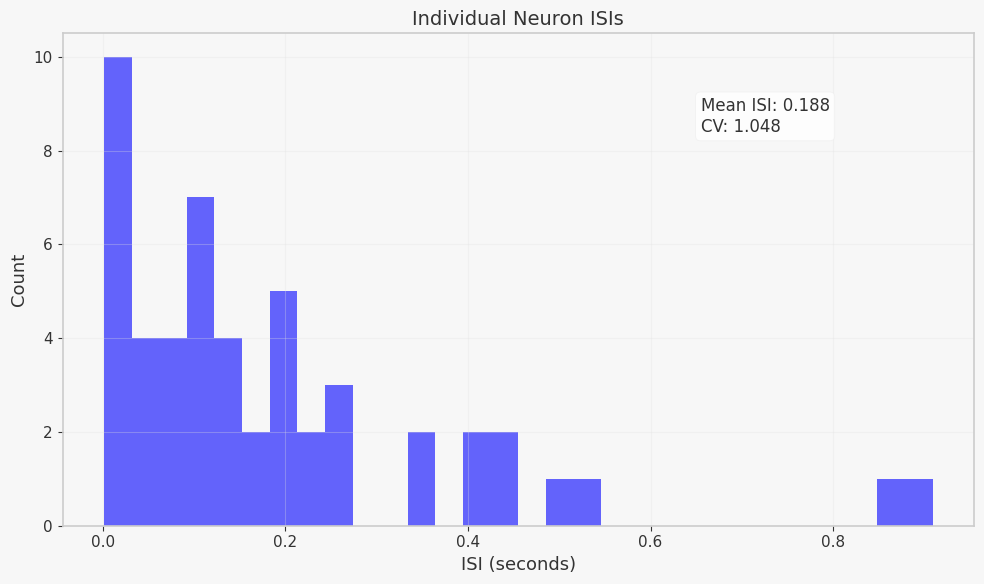


ISI Distribution Features:
- Mean ISI indicates average firing interval
- CV (Coefficient of Variation) measures regularity:
  * CV < 1: Regular firing
  * CV ≈ 1: Poisson-like firing
  * CV > 1: Irregular/bursty firing
- Log scale helps visualize wide ISI ranges
- Individual neuron analysis reveals firing patterns


In [6]:
# ISI distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Basic ISI distribution
braintools.visualize.isi_distribution(spike_trains,
                                      ax=axes[0, 0],
                                      title="ISI Distribution (All Neurons)",
                                      bins=50,
                                      color='skyblue')

# 2. Log-scale ISI distribution
braintools.visualize.isi_distribution(spike_trains,
                                      ax=axes[0, 1],
                                      title="ISI Distribution (Log Scale)",
                                      bins=50,
                                      log_scale=True,
                                      color='orange')

# 3. ISI for individual neurons
# Select a few neurons with different firing patterns
selected_neurons = [0, 15, 30]
colors = ['red', 'green', 'blue']

for i, (neuron_idx, color) in enumerate(zip(selected_neurons, colors)):
    if len(spike_trains[neuron_idx]) > 1:
        braintools.visualize.isi_distribution([spike_trains[neuron_idx]],
                                              ax=axes[1, 0] if i == 0 else None,
                                              title="Individual Neuron ISIs",
                                              bins=30, color=color, alpha=0.6,
                                              xlabel="ISI (seconds)",
                                              ylabel="Count")
        if i == 0:
            axes[1, 0].legend([f'Neuron {idx}' for idx in selected_neurons])

# 4. ISI with maximum cutoff
braintools.visualize.isi_distribution(spike_trains,
                                      ax=axes[1, 1],
                                      title="ISI Distribution (max_isi=0.5s)",
                                      bins=40,
                                      max_isi=0.5,
                                      color='purple')

plt.tight_layout()
plt.show()

print("\nISI Distribution Features:")
print("- Mean ISI indicates average firing interval")
print("- CV (Coefficient of Variation) measures regularity:")
print("  * CV < 1: Regular firing")
print("  * CV ≈ 1: Poisson-like firing")
print("  * CV > 1: Irregular/bursty firing")
print("- Log scale helps visualize wide ISI ranges")
print("- Individual neuron analysis reveals firing patterns")

## 6. Spike Histograms (PSTH)

Peri-Stimulus Time Histograms (PSTH) show the distribution of spike times, often used to analyze responses to stimuli.

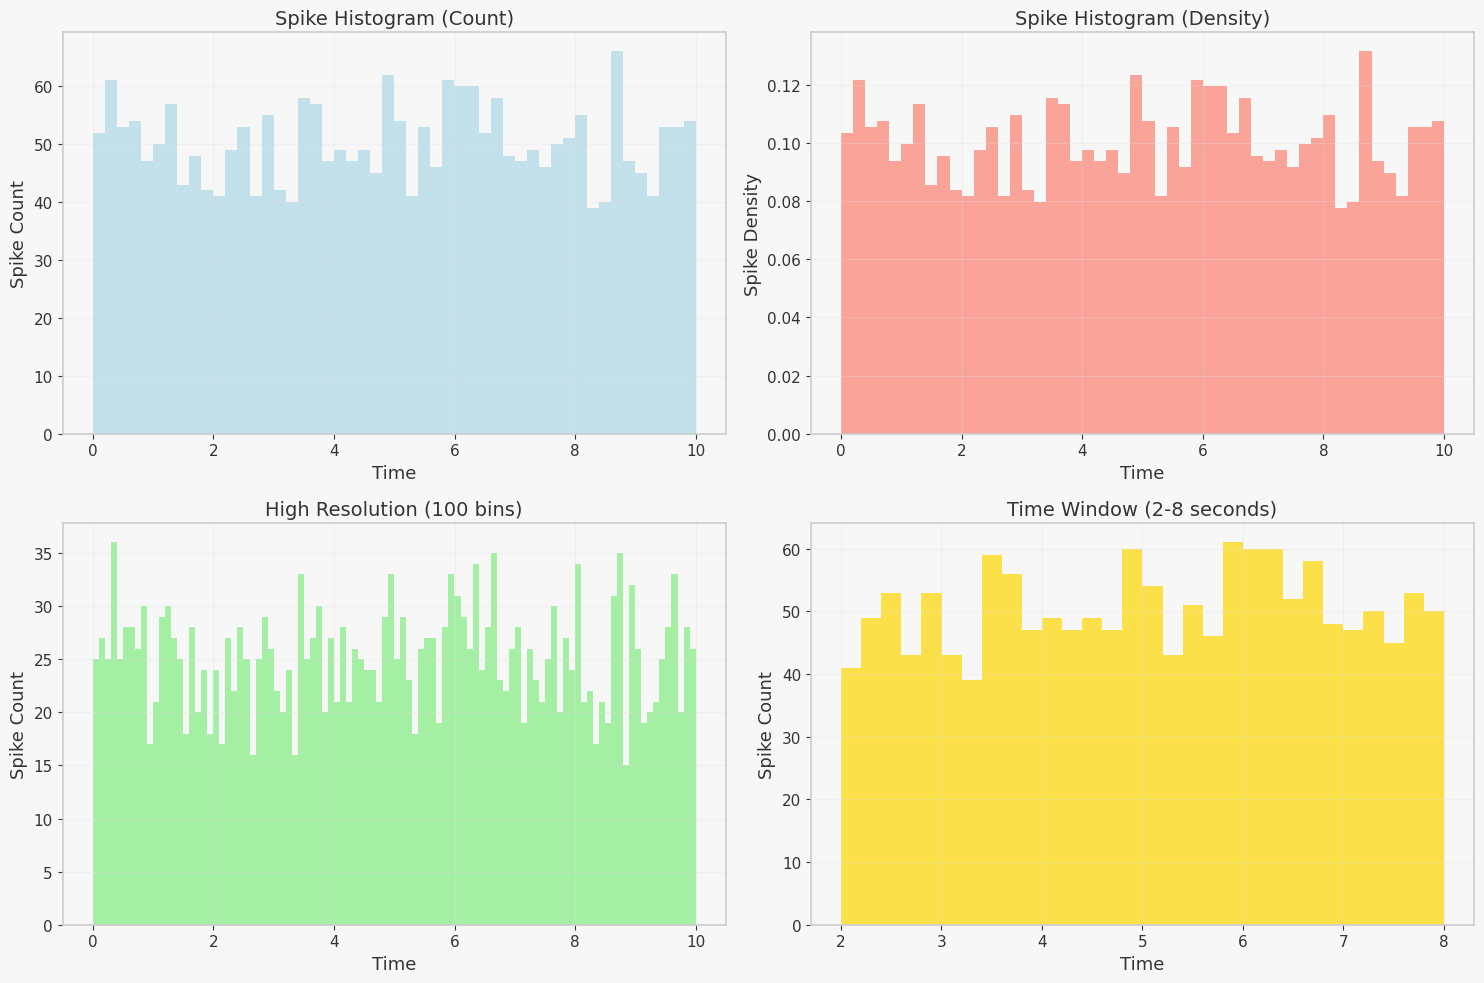


Spike Histogram Features:
- Shows temporal distribution of all spikes
- Count mode: actual number of spikes per bin
- Density mode: normalized by bin width and total count
- Bin size affects temporal resolution
- Time windowing allows focus on specific periods
- Useful for detecting temporal patterns and stimulus responses


In [7]:
# Spike histogram analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Basic spike histogram
braintools.visualize.spike_histogram(spike_trains,
                                     ax=axes[0, 0],
                                     title="Spike Histogram (Count)",
                                     bins=50,
                                     color='lightblue')

# 2. Density histogram
braintools.visualize.spike_histogram(spike_trains,
                                     ax=axes[0, 1],
                                     title="Spike Histogram (Density)",
                                     bins=50,
                                     density=True,
                                     color='salmon')

# 3. High-resolution histogram
braintools.visualize.spike_histogram(spike_trains, ax=axes[1, 0],
                                     title="High Resolution (100 bins)",
                                     bins=100, color='lightgreen', alpha=0.8)

# 4. Histogram with specific time window
braintools.visualize.spike_histogram(spike_trains,
                                     ax=axes[1, 1],
                                     title="Time Window (2-8 seconds)",
                                     bins=30,
                                     time_range=(2, 8),
                                     color='gold')

plt.tight_layout()
plt.show()

print("\nSpike Histogram Features:")
print("- Shows temporal distribution of all spikes")
print("- Count mode: actual number of spikes per bin")
print("- Density mode: normalized by bin width and total count")
print("- Bin size affects temporal resolution")
print("- Time windowing allows focus on specific periods")
print("- Useful for detecting temporal patterns and stimulus responses")

## 7. Firing Rate Maps

Firing rate maps visualize spatial patterns of neural activity, commonly used for place cells and grid cells.

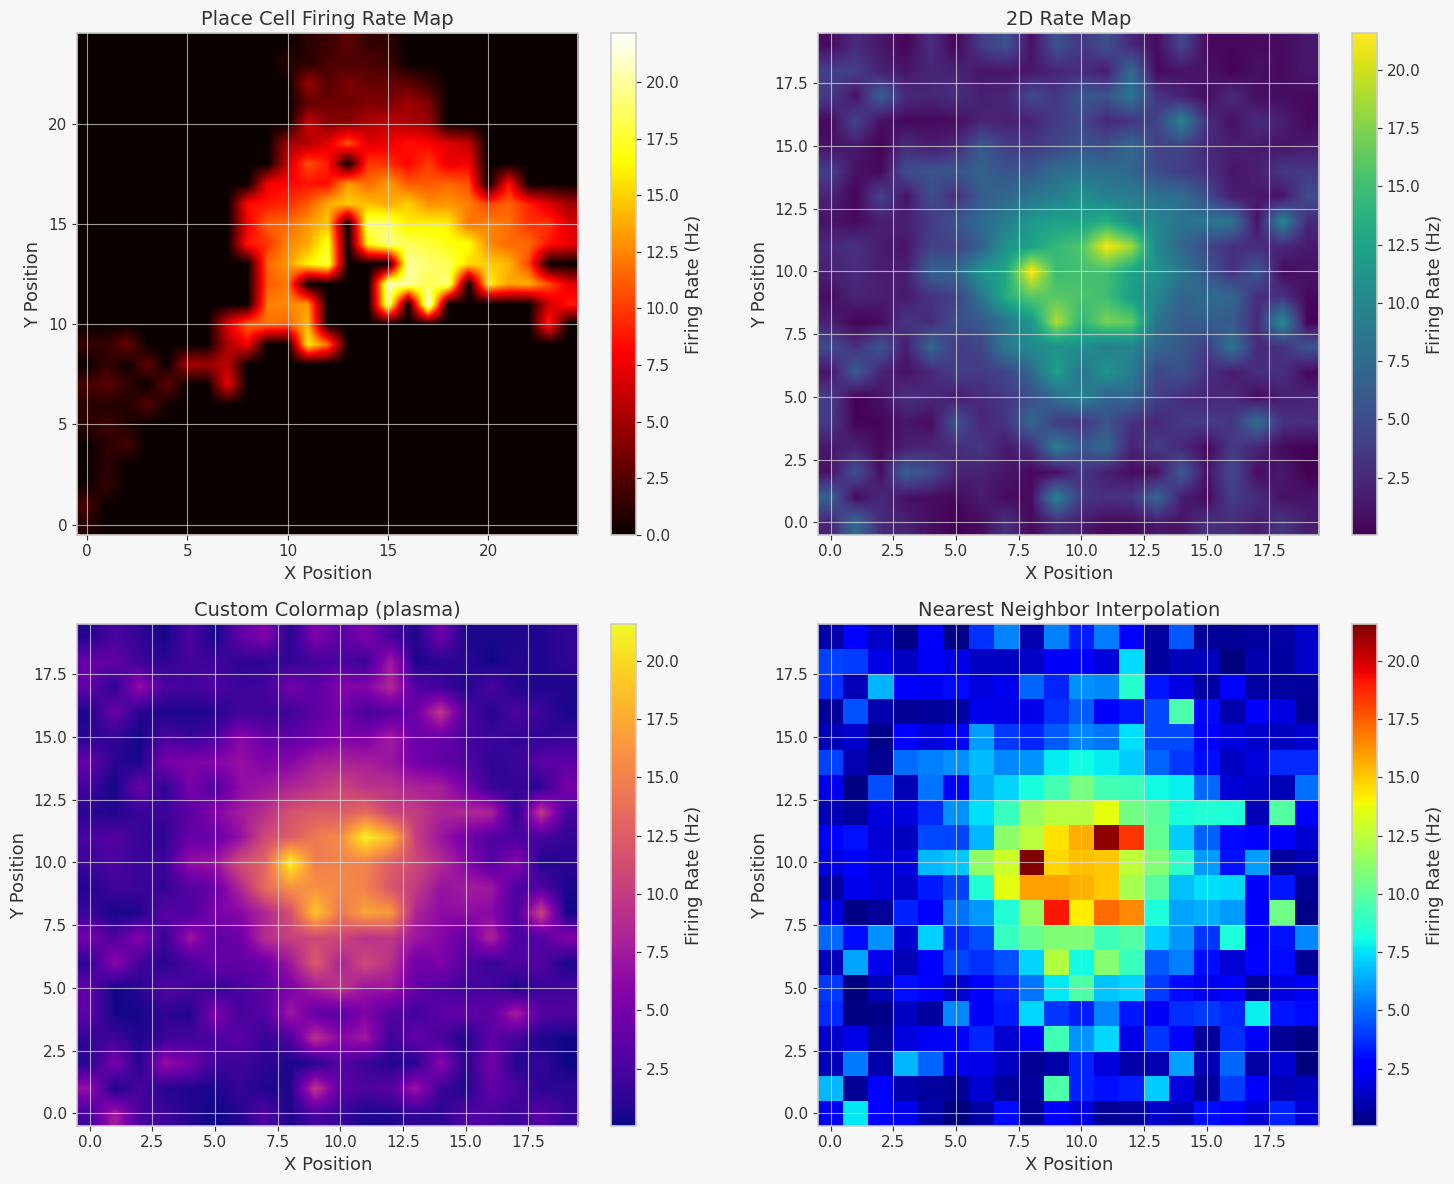


Firing Rate Map Features:
- Visualizes spatial firing patterns
- Can be generated from position-rate pairs or 2D arrays
- Different colormaps highlight different aspects
- Interpolation methods affect smoothness
- Commonly used for place cells, grid cells, and spatial analysis
- Hot colors typically represent high firing rates


In [8]:
# Generate spatial firing rate data
def generate_spatial_data(n_positions=1000, arena_size=1.0):
    """
    Generate simulated spatial firing data for place cells.
    """
    # Random walk trajectory
    positions = np.zeros((n_positions, 2))
    for i in range(1, n_positions):
        step = np.random.normal(0, 0.02, 2)
        new_pos = positions[i - 1] + step
        # Keep within arena bounds
        new_pos = np.clip(new_pos, 0, arena_size)
        positions[i] = new_pos

    # Generate place field (Gaussian)
    field_center = np.array([0.5, 0.5])  # Center of arena
    field_width = 0.2

    # Calculate firing rates based on distance from field center
    distances = np.linalg.norm(positions - field_center, axis=1)
    firing_rates = 20 * np.exp(-(distances ** 2) / (2 * field_width ** 2))

    # Add noise
    firing_rates += np.random.normal(0, 2, len(firing_rates))
    firing_rates = np.maximum(firing_rates, 0)  # Ensure non-negative

    return positions, firing_rates


# Generate spatial data
positions, firing_rates = generate_spatial_data()

# Create 2D rate map manually for comparison
grid_size = 20
rate_map_2d = np.random.exponential(2, (grid_size, grid_size))
# Add a "hot spot" in the center
center = grid_size // 2
y, x = np.ogrid[:grid_size, :grid_size]
dist_from_center = np.sqrt((x - center) ** 2 + (y - center) ** 2)
rate_map_2d += 15 * np.exp(-dist_from_center ** 2 / 20)

# Firing rate map visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Rate map from positions and rates
braintools.visualize.firing_rate_map(firing_rates, positions=positions, ax=axes[0, 0],
                                     title="Place Cell Firing Rate Map",
                                     cmap='hot', grid_size=(25, 25))

# 2. 2D rate map
braintools.visualize.firing_rate_map(rate_map_2d, ax=axes[0, 1],
                                     title="2D Rate Map",
                                     cmap='viridis', interpolation='bilinear')

# 3. Different colormap
braintools.visualize.firing_rate_map(rate_map_2d, ax=axes[1, 0],
                                     title="Custom Colormap (plasma)",
                                     cmap='plasma', show_colorbar=True)

# 4. Nearest neighbor interpolation
braintools.visualize.firing_rate_map(rate_map_2d, ax=axes[1, 1],
                                     title="Nearest Neighbor Interpolation",
                                     cmap='jet', interpolation='nearest')

plt.tight_layout()
plt.show()

print("\nFiring Rate Map Features:")
print("- Visualizes spatial firing patterns")
print("- Can be generated from position-rate pairs or 2D arrays")
print("- Different colormaps highlight different aspects")
print("- Interpolation methods affect smoothness")
print("- Commonly used for place cells, grid cells, and spatial analysis")
print("- Hot colors typically represent high firing rates")

## 8. Comprehensive Neural Dashboard

Let's create a comprehensive dashboard that combines multiple visualization types for a complete view of neural activity.

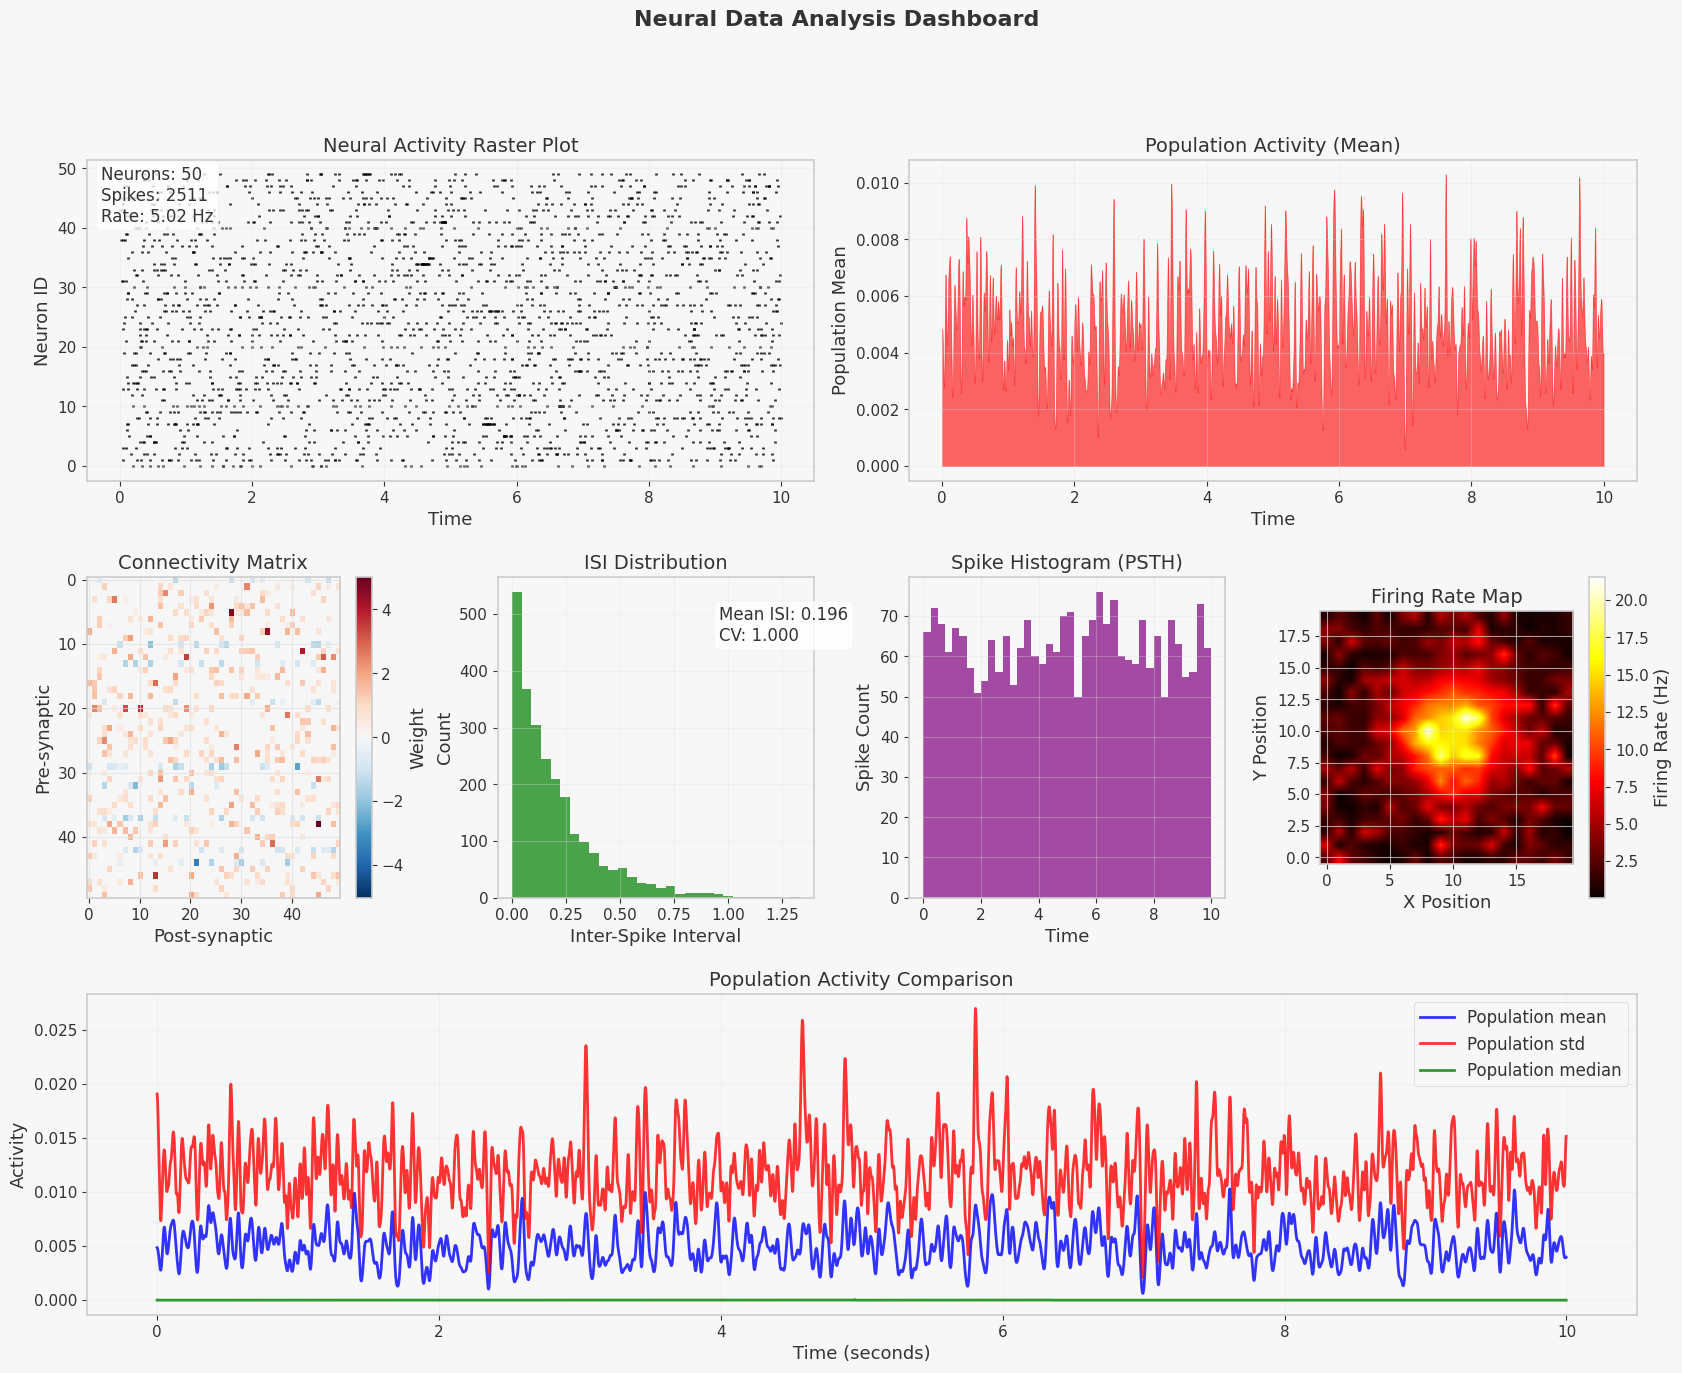


Comprehensive Dashboard Features:
- Multiple visualization types in one view
- Spike raster shows individual neuron activity
- Population activity reveals network dynamics
- Connectivity matrix shows network structure
- ISI and spike histograms reveal firing patterns
- Firing rate maps show spatial organization
- Comparison plots highlight different aspects


In [9]:
# Create a comprehensive neural activity dashboard
fig = plt.figure(figsize=(20, 15))

# Define grid layout
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Spike raster (top row, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
braintools.visualize.spike_raster(spike_trains,
                                  ax=ax1,
                                  title="Neural Activity Raster Plot",
                                  show_stats=True,
                                  alpha=0.8)

# 2. Population activity (top row, spans 2 columns)
ax2 = fig.add_subplot(gs[0, 2:])
braintools.visualize.population_activity(population_data,
                                         time=time_bins,
                                         method='mean',
                                         ax=ax2,
                                         title="Population Activity (Mean)",
                                         color='red',
                                         fill=True,
                                         alpha=0.6)

# 3. Connectivity matrix (middle left)
ax3 = fig.add_subplot(gs[1, 0])
braintools.visualize.connectivity_matrix(connectivity_matrix,
                                         ax=ax3,
                                         title="Connectivity Matrix",
                                         cmap='RdBu_r',
                                         center_zero=True)

# 4. ISI distribution (middle center-left)
ax4 = fig.add_subplot(gs[1, 1])
braintools.visualize.isi_distribution(spike_trains,
                                      ax=ax4,
                                      title="ISI Distribution",
                                      bins=30,
                                      color='green',
                                      alpha=0.7)

# 5. Spike histogram (middle center-right)
ax5 = fig.add_subplot(gs[1, 2])
braintools.visualize.spike_histogram(spike_trains,
                                     ax=ax5,
                                     title="Spike Histogram (PSTH)",
                                     bins=40,
                                     color='purple',
                                     alpha=0.7)

# 6. Firing rate map (middle right)
ax6 = fig.add_subplot(gs[1, 3])
braintools.visualize.firing_rate_map(rate_map_2d,
                                     ax=ax6,
                                     title="Firing Rate Map",
                                     cmap='hot')

# 7. Population activity comparison (bottom row, spans all columns)
ax7 = fig.add_subplot(gs[2, :])
methods = ['mean', 'std', 'median']
colors = ['blue', 'red', 'green']
for method, color in zip(methods, colors):
    # Calculate population activity for each method
    if method == 'mean':
        activity = np.mean(population_data, axis=1)
    elif method == 'std':
        activity = np.std(population_data, axis=1)
    elif method == 'median':
        activity = np.median(population_data, axis=1)

    ax7.plot(time_bins, activity, color=color, alpha=0.8,
             linewidth=2, label=f'Population {method}')

ax7.set_xlabel('Time (seconds)')
ax7.set_ylabel('Activity')
ax7.set_title('Population Activity Comparison')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Add overall title
fig.suptitle('Neural Data Analysis Dashboard', fontsize=16, fontweight='bold')

plt.show()

print("\nComprehensive Dashboard Features:")
print("- Multiple visualization types in one view")
print("- Spike raster shows individual neuron activity")
print("- Population activity reveals network dynamics")
print("- Connectivity matrix shows network structure")
print("- ISI and spike histograms reveal firing patterns")
print("- Firing rate maps show spatial organization")
print("- Comparison plots highlight different aspects")

## 9. Styling and Customization

BrainTools provides various styling options for publication-ready figures.

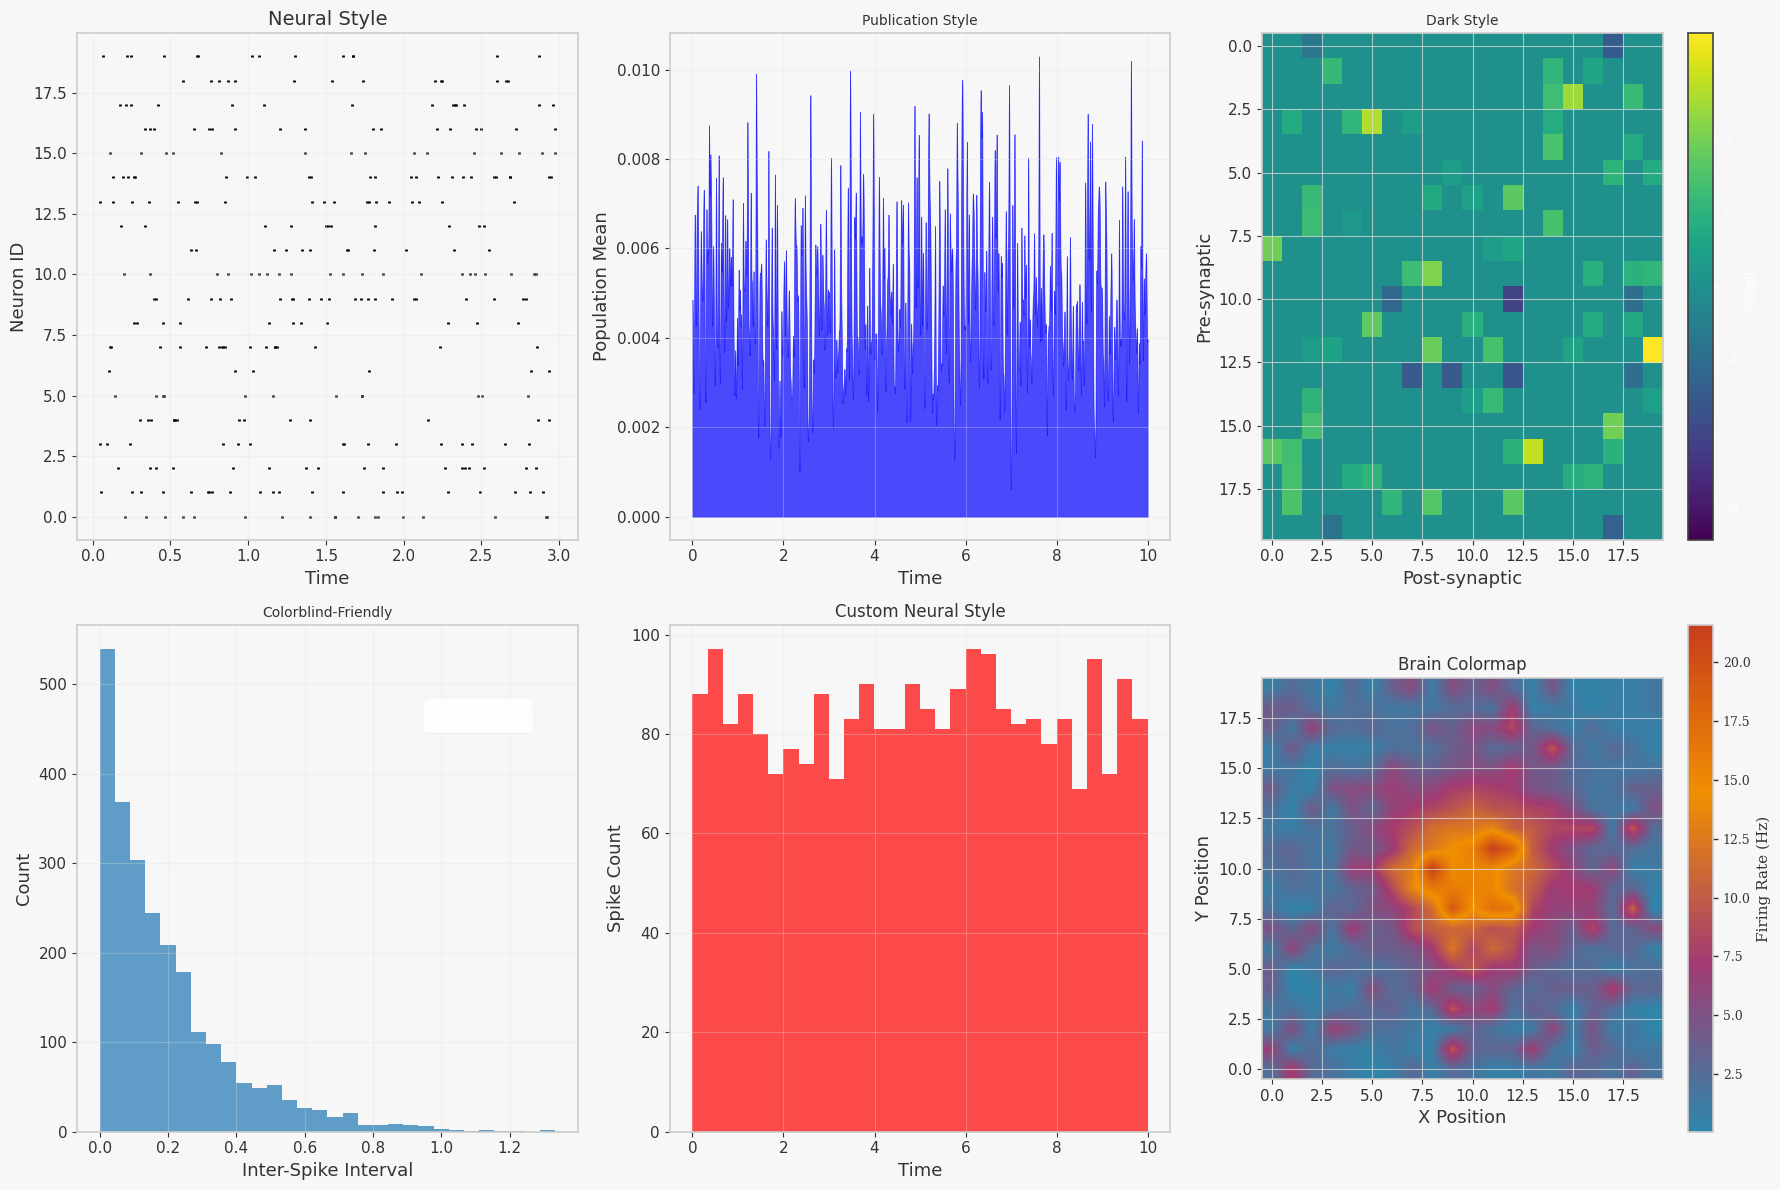


Styling Options:
- neural_style(): Optimized for neural data visualization
- publication_style(): Clean, publication-ready formatting
- dark_style(): Dark theme for presentations
- colorblind_friendly_style(): Accessible color palette
- brain_colormaps(): Specialized colormaps for neural data
- All styles can be customized with parameters


In [10]:
# Demonstrate different styling options
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Reset to default style first
plt.rcdefaults()

# 1. Neural style
braintools.visualize.neural_style()
braintools.visualize.spike_raster(spike_trains[:20],
                                  ax=axes[0, 0],
                                  title="Neural Style",
                                  time_range=(0, 3))

# 2. Publication style
braintools.visualize.publication_style(fontsize=9)
braintools.visualize.population_activity(population_data,
                                         time=time_bins,
                                         method='mean',
                                         ax=axes[0, 1],
                                         title="Publication Style")

# 3. Dark style
braintools.visualize.dark_style()
braintools.visualize.connectivity_matrix(connectivity_matrix[:20, :20],
                                         ax=axes[0, 2],
                                         title="Dark Style",
                                         cmap='viridis')

# 4. Colorblind-friendly style
braintools.visualize.colorblind_friendly_style()
braintools.visualize.isi_distribution(spike_trains,
                                      ax=axes[1, 0],
                                      title="Colorblind-Friendly",
                                      bins=30,
                                      color='tab:blue')

# 5. Custom neural style
braintools.visualize.neural_style(spike_color='red',
                                  membrane_color='blue',
                                  background_color='white',
                                  fontsize=10)
braintools.visualize.spike_histogram(spike_trains,
                                     ax=axes[1, 1],
                                     title="Custom Neural Style",
                                     bins=30,
                                     color='red')

# 6. Brain colormaps
braintools.visualize.brain_colormaps()  # Register custom colormaps
braintools.visualize.firing_rate_map(rate_map_2d,
                                     ax=axes[1, 2],
                                     title="Brain Colormap",
                                     cmap='membrane')

plt.tight_layout()
plt.show()

print("\nStyling Options:")
print("- neural_style(): Optimized for neural data visualization")
print("- publication_style(): Clean, publication-ready formatting")
print("- dark_style(): Dark theme for presentations")
print("- colorblind_friendly_style(): Accessible color palette")
print("- brain_colormaps(): Specialized colormaps for neural data")
print("- All styles can be customized with parameters")